In [1]:
import dropkick as dk
from H2TL_spatial_trx import *

# some stuff to make this notebook work better with Scanpy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

---
### Read in Visium ST Anndata

In [2]:
a1 = sc.read("data/V1_Breast_Cancer_Block_A_Section_1_raw.h5ad"); a1

AnnData object with n_obs × n_vars = 4992 × 25062
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
a2 = sc.read("data/V1_Breast_Cancer_Block_A_Section_2_raw.h5ad"); a2

AnnData object with n_obs × n_vars = 4992 × 25149
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

---
### Map ST data to histology pixels and trim images

In [4]:
a1 = map_pixels(a1, filter_label="in_tissue")

Creating pixel grid and mapping to nearest barcode coordinates
Saving barcode mapping to adata.uns['pixel_map_df'] and adding metadata
Filtering barcodes using labels in self.adata.obs['in_tissue']
New size: 3798 spots x 25062 genes
Done!


Cropping image to pixel dimensions and adding values to adata.uns['pixel_map_df']
Cropping Visium spot coordinates and saving to adata.obsm['spatial_trim']
Saving cropped and trimmed image to adata.uns['spatial']['V1_Breast_Cancer_Block_A_Section_1']['images']['hires_trim']
Plotting pita as RGB image
Done!


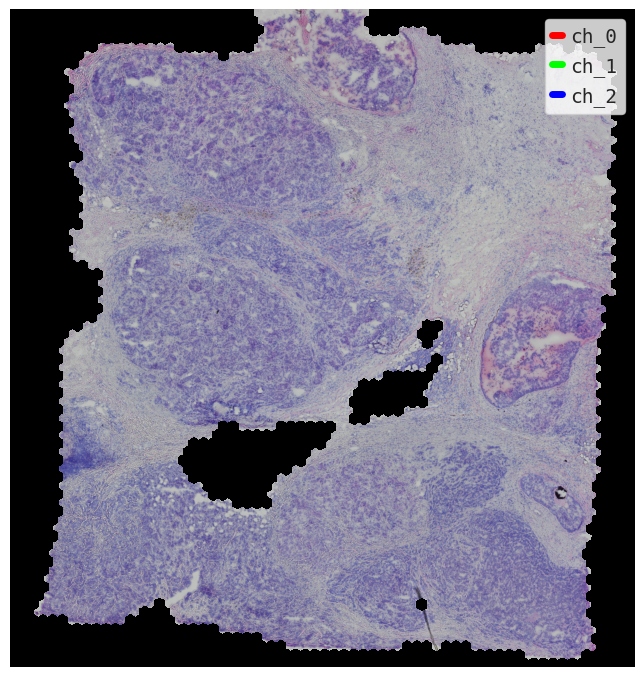

In [5]:
a1_image = trim_image(a1)

In [6]:
a2 = map_pixels(a2, filter_label="in_tissue")

Creating pixel grid and mapping to nearest barcode coordinates
Saving barcode mapping to adata.uns['pixel_map_df'] and adding metadata
Filtering barcodes using labels in self.adata.obs['in_tissue']
New size: 3987 spots x 25149 genes
Done!


In [7]:
a2_image = trim_image(a2)

Cropping image to pixel dimensions and adding values to adata.uns['pixel_map_df']
Cropping Visium spot coordinates and saving to adata.obsm['spatial_trim']
Saving cropped and trimmed image to adata.uns['spatial']['V1_Breast_Cancer_Block_A_Section_2']['images']['hires_trim']
Plotting pita as RGB image
Done!


---
### Perform joint PCA to get a low-dimensional space for clustering

In [8]:
a_comb = a1.concatenate([a2], fill_value=0, join="outer"); a_comb

AnnData object with n_obs × n_vars = 7785 × 26384
    obs: 'in_tissue', 'array_row', 'array_col', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1'
    obsm: 'spatial', 'spatial_trim', 'image_means'

In [9]:
sc.pp.normalize_total(a_comb)
sc.pp.log1p(a_comb)
sc.pp.scale(a_comb)
sc.pp.pca(a_comb, n_comps=50)

... storing 'gene_ids-0' as categorical
... storing 'gene_ids-1' as categorical


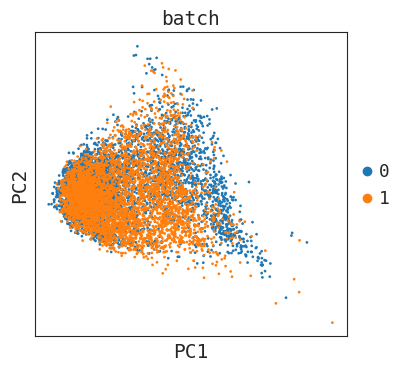

/Users/cody/.virtualenvs/sc/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/cody/.virtualenvs/sc/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


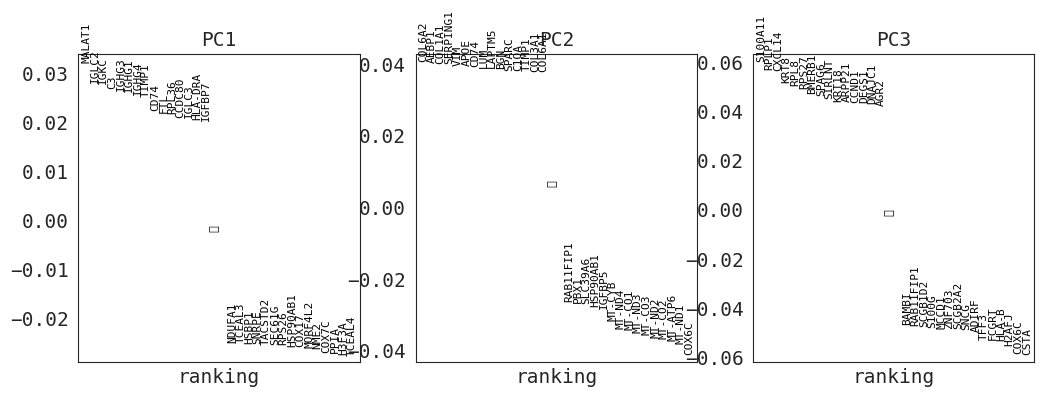

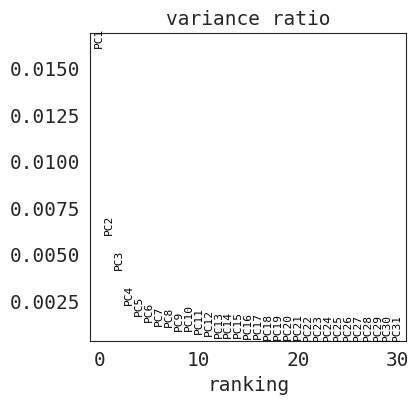

In [10]:
sc.pl.pca_overview(a_comb, color="batch")

In [11]:
# add PCA coordinates to original anndata objects
a1.obsm["X_pca"] = a_comb[a_comb.obs.batch=="0",:].obsm["X_pca"]
a2.obsm["X_pca"] = a_comb[a_comb.obs.batch=="1",:].obsm["X_pca"]

---
### Create `tissue_labeler` object and define macro clusters based on transcriptomics and histology

In [12]:
tl = tissue_labeler([a1, a2])

Initiating clusterer with 2 anndata objects


#### Since we have brightfield histology for both sections, we can set `histo=True` to include imaging features (R, G, B channels) in the clustering model

In [13]:
%time tl.prep_cluster_data(use_rep="X_pca", features=[1,2,3,4,5,6], blur_pix=2, histo=True)

Adding mean RGB histology features for adata #0
Blurring training features for adata #0
Adding mean RGB histology features for adata #1
Blurring training features for adata #1
Collected clustering data of shape: (7785, 9)
CPU times: user 50 s, sys: 34.3 ms, total: 50.1 s
Wall time: 50.1 s


#### We'll try labeling the tissue with 5 regional cluster IDs

In [14]:
%time tl.label_tissue(k=5)

Performing k-means clustering with 5 target clusters
Adding tissue_ID label to anndata objects
CPU times: user 776 ms, sys: 402 ms, total: 1.18 s
Wall time: 117 ms


#### Now show the features used for clustering after spatial blurring along with the final `tissue_ID` in each section

Assembling pita with 10 features from adata.obs
Casting barcodes to pixel dimensions and saving to adata.uns['pixel_map']
Done!
Assembling pita with 10 features from adata.obs
Casting barcodes to pixel dimensions and saving to adata.uns['pixel_map']
Done!


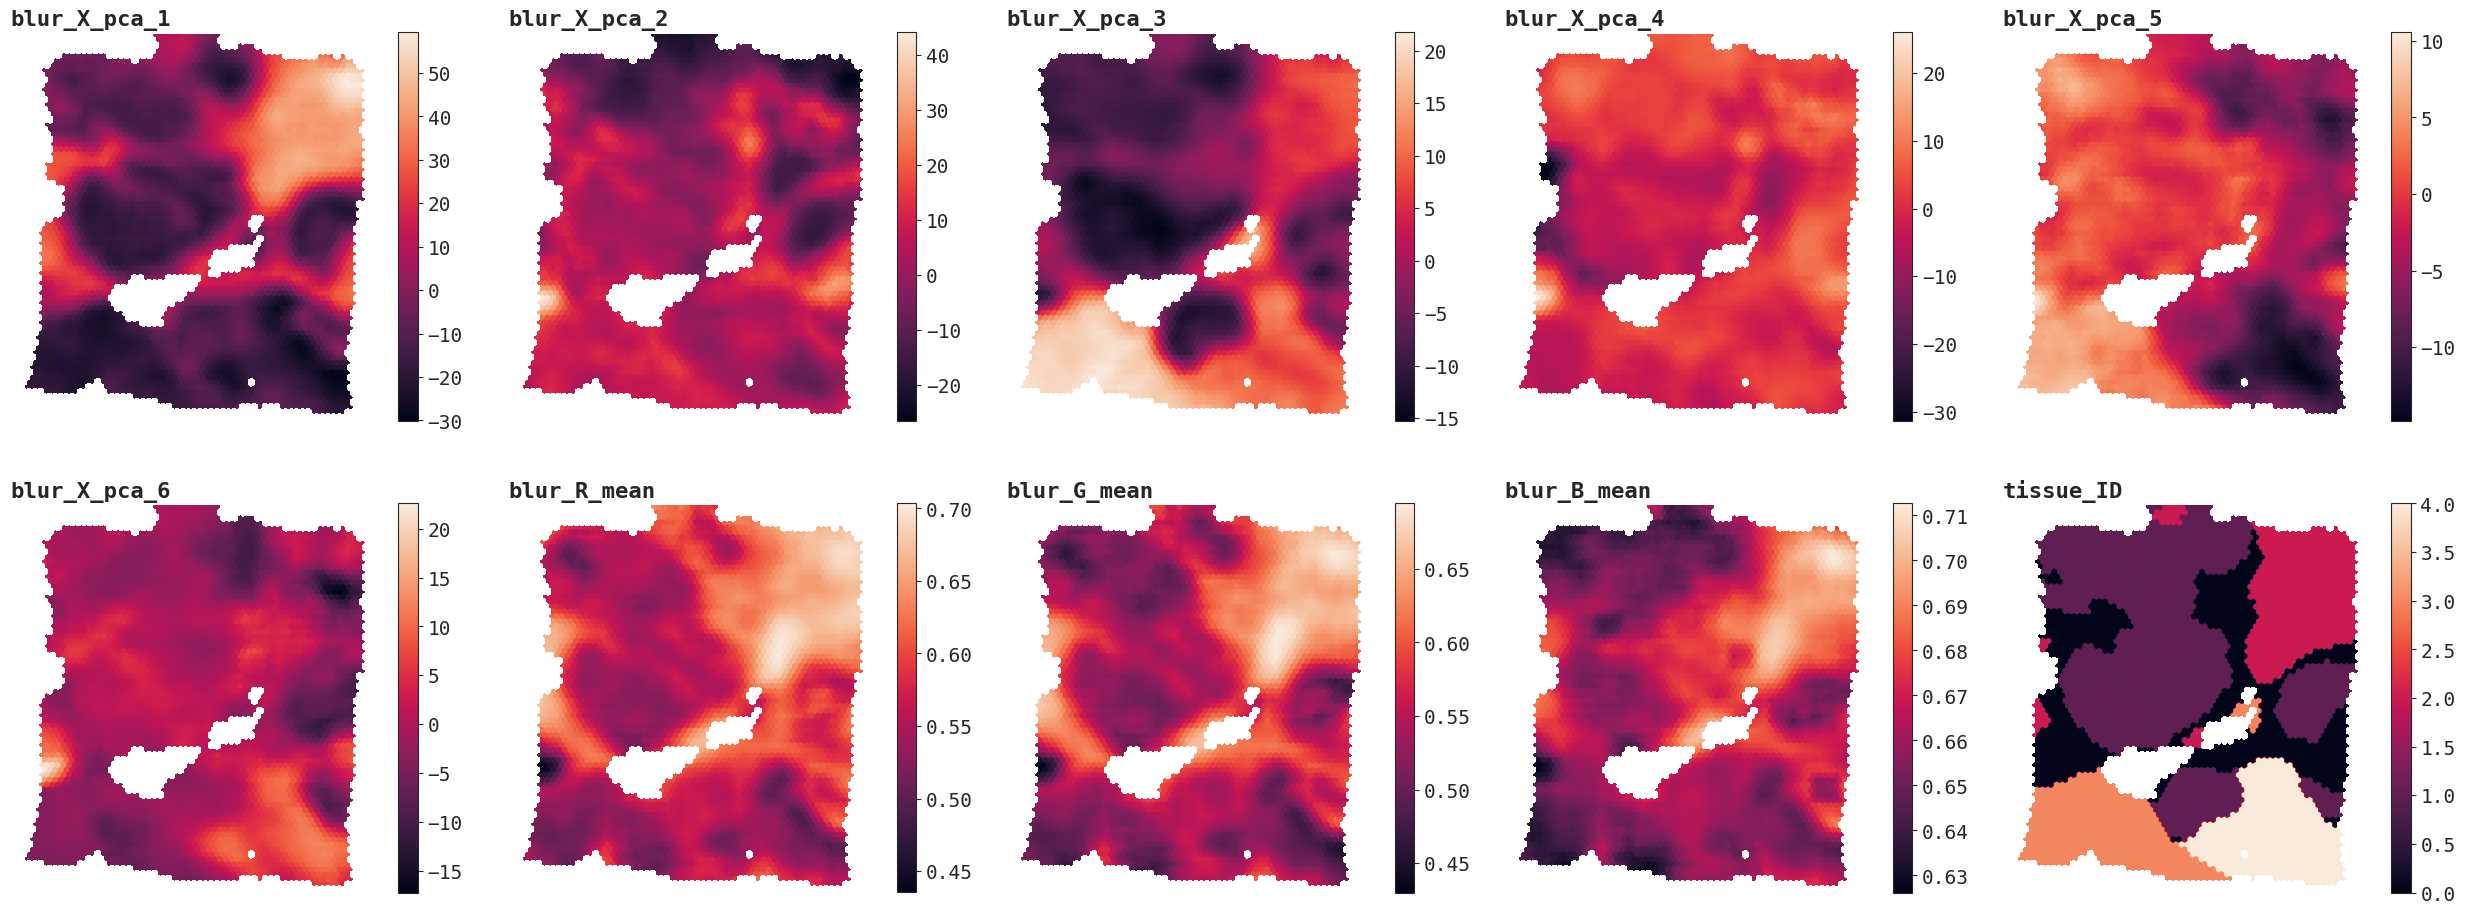

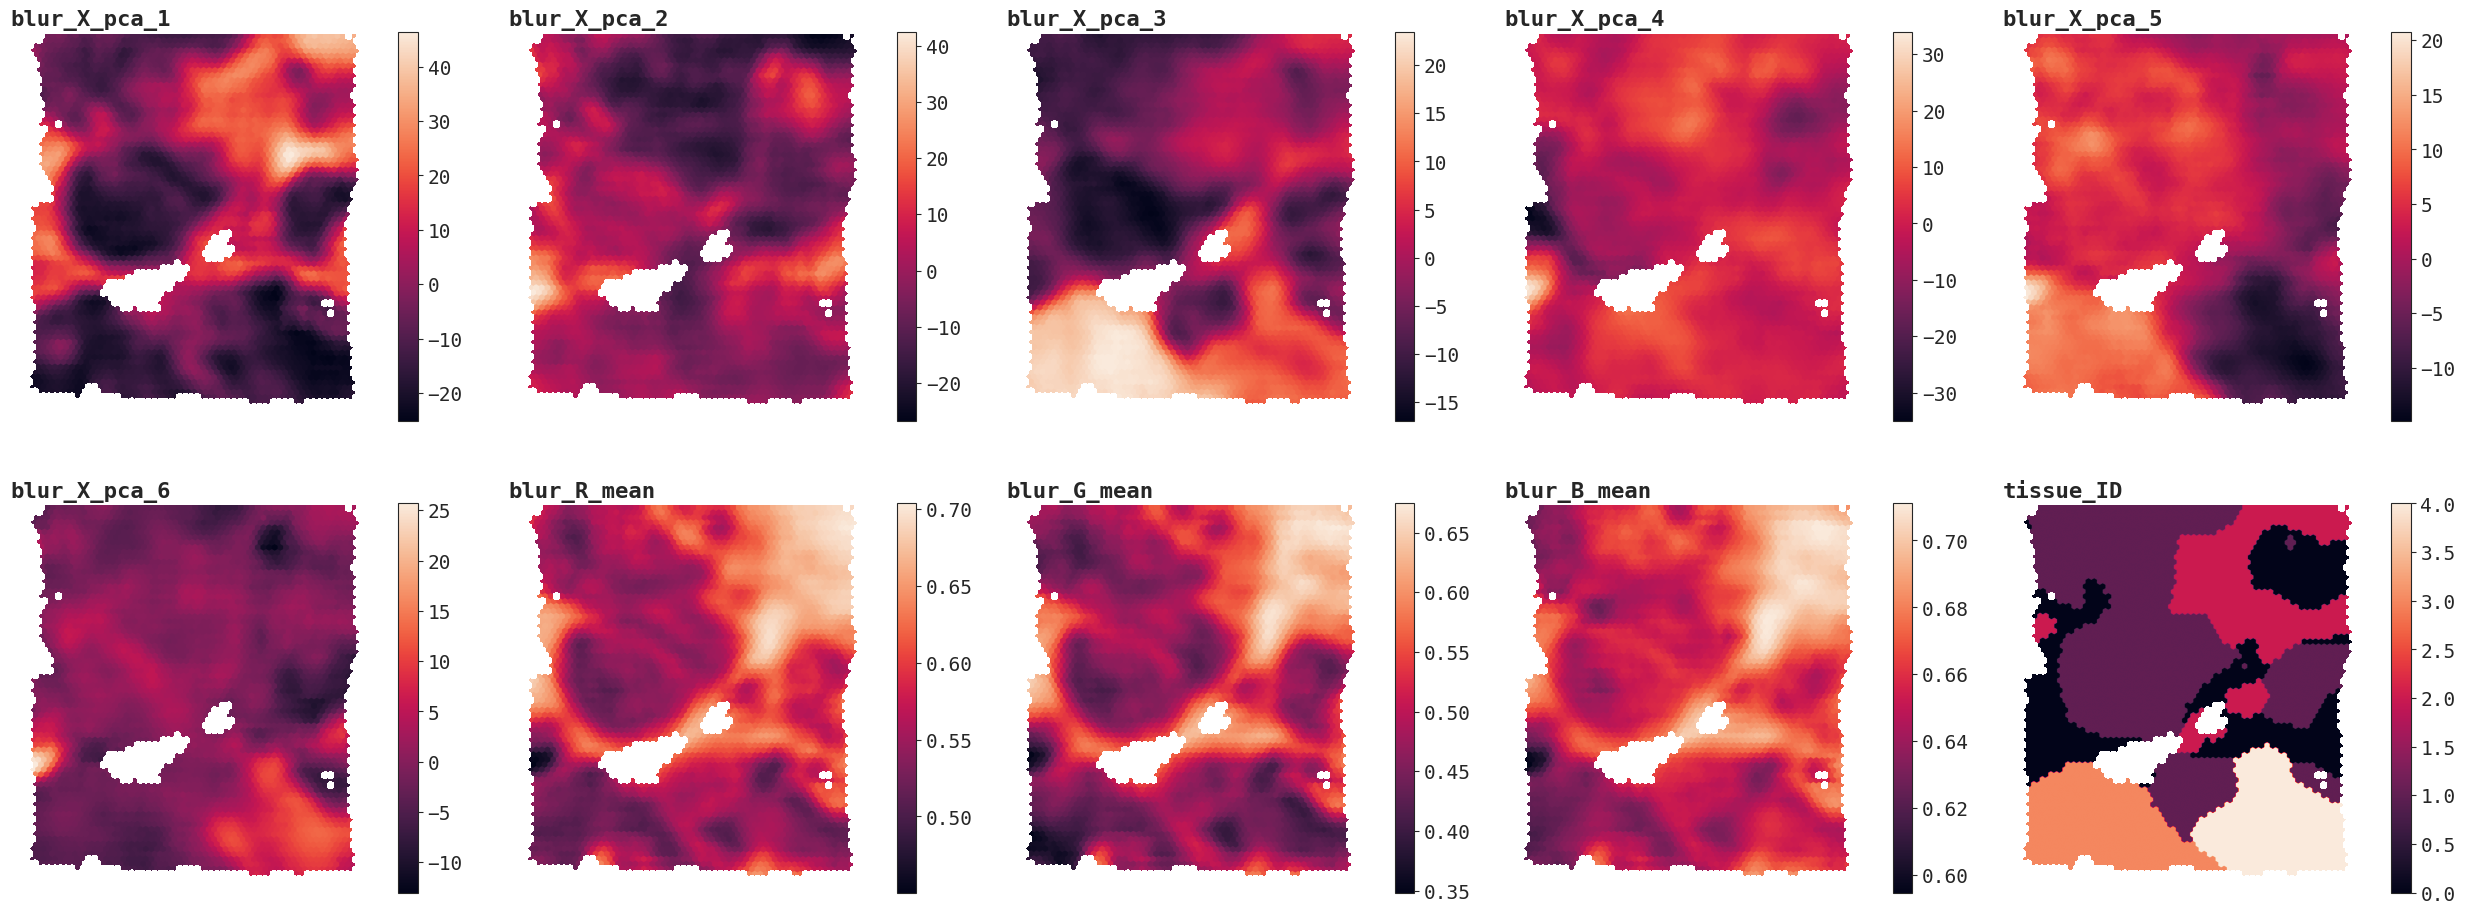

In [15]:
for i in range(len(tl.adatas)):
    n = list(tl.adatas[i].obs.columns[tl.adatas[i].obs.columns.str.startswith("blur_")]) + ["tissue_ID"]
    p = assemble_pita(tl.adatas[i], use_rep=".obs", features=n, ncols=5, label=n)